# Binarisations
## 0. Import modules

In [1]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from binaryflow.layers import XnorNet
from binaryflow import quantizers
tensorflow=tf

2022-09-05 13:47:25.068063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 13:47:25.283240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 13:47:25.283443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 13:47:25.284379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
def visualise_function(function,x1=-1,x2=1,samples=1000,iters=1,ax=None,plot_kw=None):
    if plot_kw is None:
        plot_kw={}
    B=np.zeros([iters,samples])
    X=np.zeros([iters,samples])
    for i in range(iters):
        X[i,:]=np.linspace(x1,x2,samples)
        B[i,:]=function(X[i,:])
    sns.lineplot(x=X.flatten(),y=B.flatten(),ax=ax,**plot_kw)
    return ax
import tensorflow_probability
class NormalStochasticSteSign(quantizers.StochasticSteSign):
    def __init__(self,stddev):
        super(NormalStochasticSteSign,self).__init__(distribution=tensorflow_probability.distributions.Normal(0,stddev))

## 1. Forward propagation
## 1.1 Sign

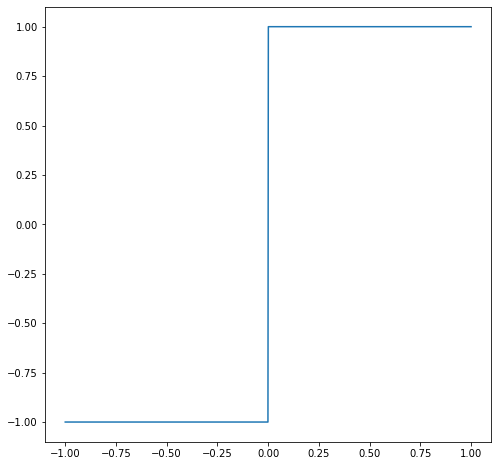

In [3]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
visualise_function(lq.quantizers.SteSign(),iters=1,ax=ax)
fig.savefig("results/sign.png")

### 1.2. Heaviside

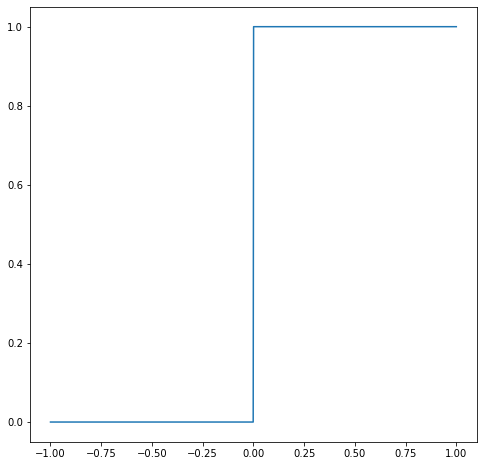

In [51]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
visualise_function(lq.quantizers.SteHeaviside(),iters=1,ax=ax)
fig.savefig("results/heaviside.png")

### 1.3. Shifted SteSign

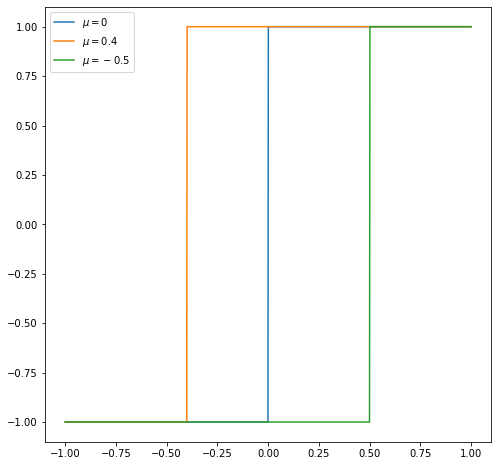

In [50]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
shifts=[0,0.4,-.5]
for shift in shifts:
    plot_kw=dict(label=fR"$\mu={shift}$")
    visualise_function(quantizers.ShiftedSteSign(shift),iters=1,ax=ax,plot_kw=plot_kw)
fig.savefig("results/shifted-ste-sign.png")

### 1.4. Stochastic SteSign

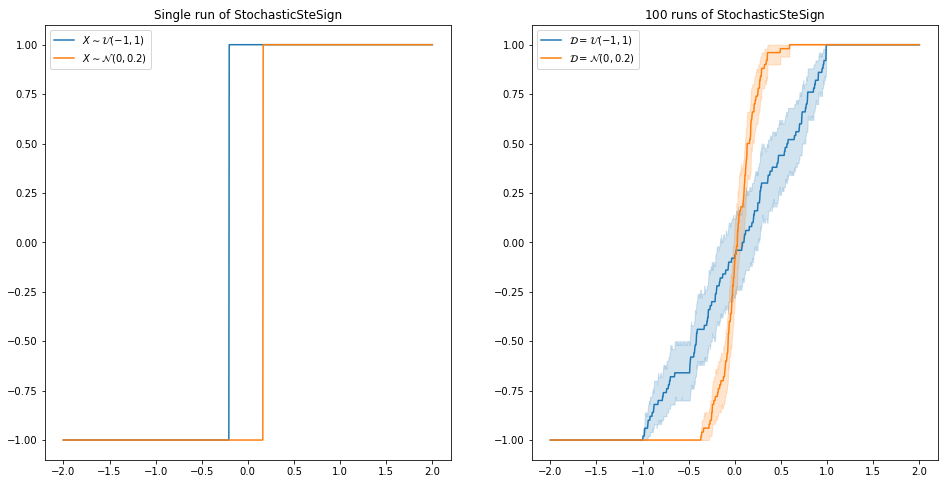

In [49]:
fig,ax=plt.subplots(1,2,figsize=(16,8))
runs=100
visualise_function(quantizers.UniformStochasticSteSign(-1,1),x1=-2,x2=2,iters=1,plot_kw={"label":R"$X \sim \mathcal{U}(-1,1)$"},ax=ax[0])
visualise_function(NormalStochasticSteSign(stddev=0.2),x1=-2,x2=2,iters=1,plot_kw={"label":R"$X \sim \mathcal{N}(0,0.2)$"},ax=ax[0])
ax[0].set_title("Single run of StochasticSteSign")
visualise_function(quantizers.UniformStochasticSteSign(-1,1),x1=-2,x2=2,iters=runs,plot_kw={"label":R"$\mathcal{D}=\mathcal{U}(-1,1)$"},ax=ax[1])
visualise_function(NormalStochasticSteSign(stddev=0.2),x1=-2,x2=2,iters=runs,plot_kw={"label":R"$\mathcal{D}=\mathcal{N}(0,0.2)$"},ax=ax[1])
ax[1].set_title(f"${runs}$ runs of StochasticSteSign")
fig.savefig("local/stochastic-ste-sign.png")

## 2. Backward propagation
### 2.1 STE 

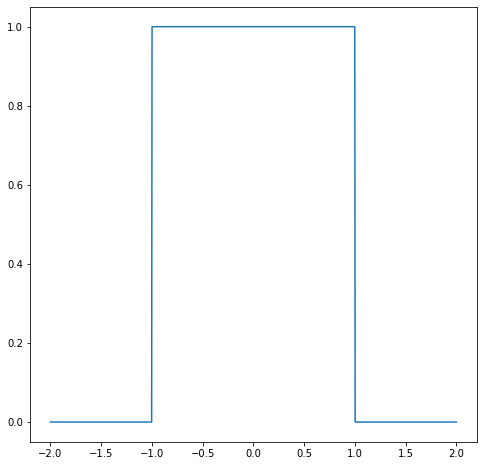

In [54]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
visualise_function(lambda x:np.abs(x)<=1,x1=-2,x2=2,ax=ax)
fig.savefig("results/ste.png")

### 2.1 ApproxSign

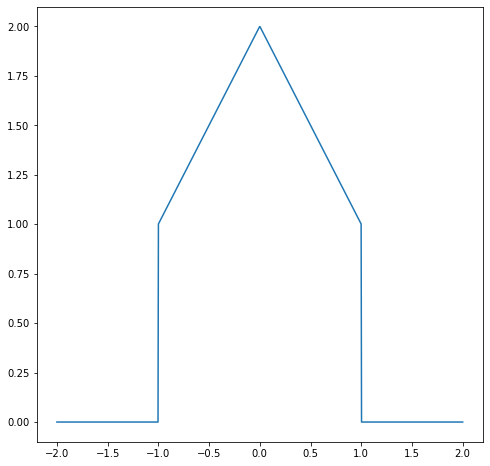

In [55]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
visualise_function(lambda x:(np.abs(x)<=1)*(2-np.abs(x)),x1=-2,x2=2,ax=ax)
fig.savefig("results/approxsign-grad.png")

### 2.3 SwishSign

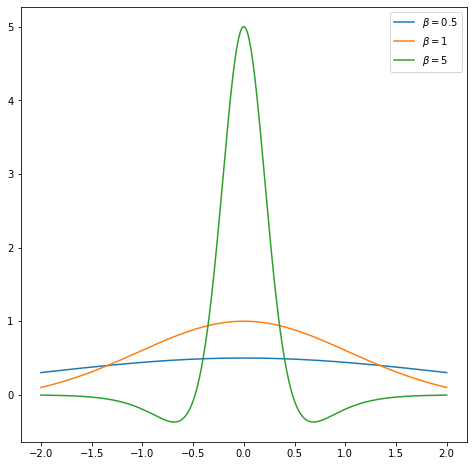

In [56]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
betas=[0.5,1,5]
def SwishGradient(x,beta):
    z=beta*x
    return beta*(2-z*np.tanh(z/2))/(1+np.cosh(z))
for beta in betas:
    plot_kw=dict(label=fR"$\beta={beta}$")
    visualise_function(lambda x:SwishGradient(x,beta),x1=-2,x2=2,iters=1,ax=ax,plot_kw=plot_kw)
fig.savefig("results/swishsign-grad.png")

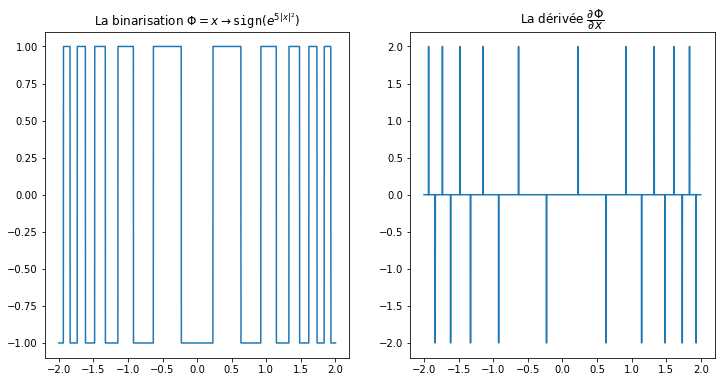

In [30]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
a0,a1=-1,1
n=2001
X=np.linspace(-2,2,2001)
Y=np.sign(np.sin(5*np.exp(np.abs(X))))
dY=(Y[1:]-Y[:-1])
sns.lineplot(x=X,y=Y,ax=ax[0])
sns.lineplot(x=X[:-1],y=dY,ax=ax[1])
ax[0].set_title(R"La binarisation $\Phi=x\rightarrow \mathtt{sign}(e^{5|x|^2}$)")
ax[1].set_title(R"La dérivée $\dfrac{\partial \Phi}{\partial x}$")
fig.savefig("results/binarisation-plot.png")
